In [5]:
import jax
import jax.numpy as jnp
import numpy as np
from fbpinns.util.logger import logger
from fbpinns.domains import RectangularDomainND
from fbpinns.problems import Problem
from fbpinns.problems import WaveEquationConstantVelocity3D
from fbpinns.decompositions import RectangularDecompositionND
from fbpinns.networks import FCN,AdaptiveFCN,FourierFCN
from fbpinns.constants import Constants, get_subdomain_ws
from fbpinns.trainers import FBPINNTrainer, PINNTrainer,PINN_model_jit,FBPINN_model_jit,get_inputs
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_2D_pressure_second_order import seismicCPML2D
import time
import matplotlib.pyplot as plt
from fbpinns.traditional_solutions.seismic_cpml.seismic_CPML_helper import get_dampening_profiles

In [6]:

class WaveEquationInterfaceVelocity3D2(WaveEquationConstantVelocity3D):

    @staticmethod
    def init_params(c0=1,c1=3,
                    source=np.array([[-0.5, 0., 0.1, 1.]])):

        static_params = {
            "dims":(1,3),
             'c0':c0,
              'c1':c1,   
            "c_fn":WaveEquationInterfaceVelocity3D2.c_fn,# velocity function
            "source":jnp.array(source),# location, width and amplitude of initial gaussian sources (k, 4)
            }
        return static_params, {}
    
    @staticmethod
    def c_fn(all_params, x_batch):
        "Computes the velocity model"
    
        p = all_params["static"]["problem"]
        c0, c1 = p["c0"], p["c1"]
    
        x = x_batch[:,0:1]
        c = c0 + (c1-c0)*(1+jnp.tanh(x/0.1))/2
    
        return c

 

subdomain_xs = [np.linspace(-1,1,5), np.linspace(-1,1,5), np.linspace(0,1,5)]
subdomain_ws = get_subdomain_ws(subdomain_xs, 1.9)


In [7]:
c = Constants(
    run="test",
    domain=RectangularDomainND,
    domain_init_kwargs=dict(
        xmin=np.array([-1,-1,0]),
        xmax=np.array([1,1,1]),
    ),
    problem=WaveEquationInterfaceVelocity3D2,
    problem_init_kwargs=dict(),
    decomposition=RectangularDecompositionND,
    decomposition_init_kwargs=dict(
        subdomain_xs=subdomain_xs,
        subdomain_ws=subdomain_ws,
        unnorm=(0.,1.),
    ),
    network=AdaptiveFCN,
    network_init_kwargs=dict(
        layer_sizes=[3,32,32,1],
    ),
    ns=((50,50,50),),
    n_test=(50,50,10),
    n_steps=50000,
    optimiser_kwargs=dict(learning_rate=1e-3),
    summary_freq=200,
    test_freq=1000,
    show_figures=True,
    clear_output=True,
)

#run = FBPINNTrainer(c)
#run.train()

c["network_init_kwargs"] = dict(layer_sizes=[3,64,64,64,1])


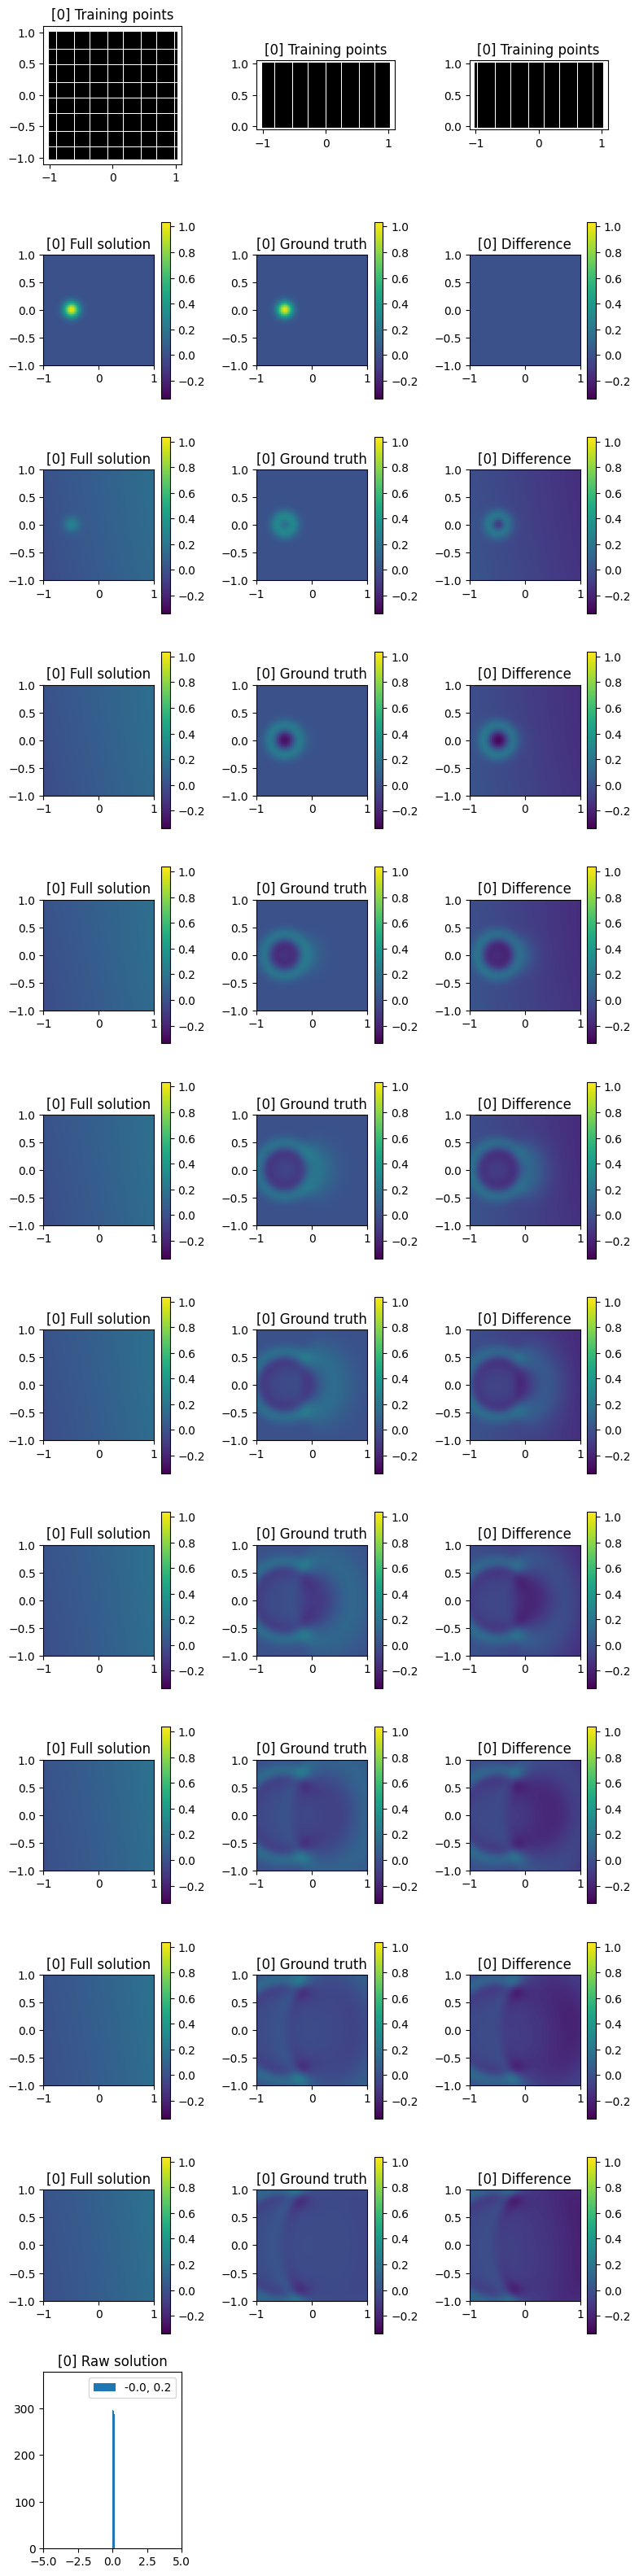

Iteration:: 0  Loss value 32.194164
Iteration:: 100  Loss value 16.260883
[INFO] 2024-10-08 14:08:42 - [i: 200/50000] loss: 15.8890 rate: 26.4 elapsed: 0.00 hr test
Iteration:: 200  Loss value 15.886779
Iteration:: 300  Loss value 15.728246
[INFO] 2024-10-08 14:08:51 - [i: 400/50000] loss: 15.5913 rate: 26.3 elapsed: 0.01 hr test
Iteration:: 400  Loss value 15.5895605
Iteration:: 500  Loss value 15.405492
[INFO] 2024-10-08 14:09:00 - [i: 600/50000] loss: 14.6393 rate: 26.4 elapsed: 0.01 hr test
Iteration:: 600  Loss value 14.623731
Iteration:: 700  Loss value 12.855871
[INFO] 2024-10-08 14:09:09 - [i: 800/50000] loss: 12.0376 rate: 26.5 elapsed: 0.01 hr test
Iteration:: 800  Loss value 11.966589
Iteration:: 900  Loss value 11.423489
[INFO] 2024-10-08 14:09:18 - [i: 1000/50000] loss: 10.2176 rate: 26.4 elapsed: 0.01 hr test
Iteration:: 1000  Loss value 10.211186
Iteration:: 1100  Loss value 9.701396
[INFO] 2024-10-08 14:09:27 - [i: 1200/50000] loss: 9.0804 rate: 26.4 elapsed: 0.02 hr te

KeyboardInterrupt: 

In [8]:
run = PINNTrainer(c)
all_params2,loss_log2,x_batch_test2,model_fns2= run.train()

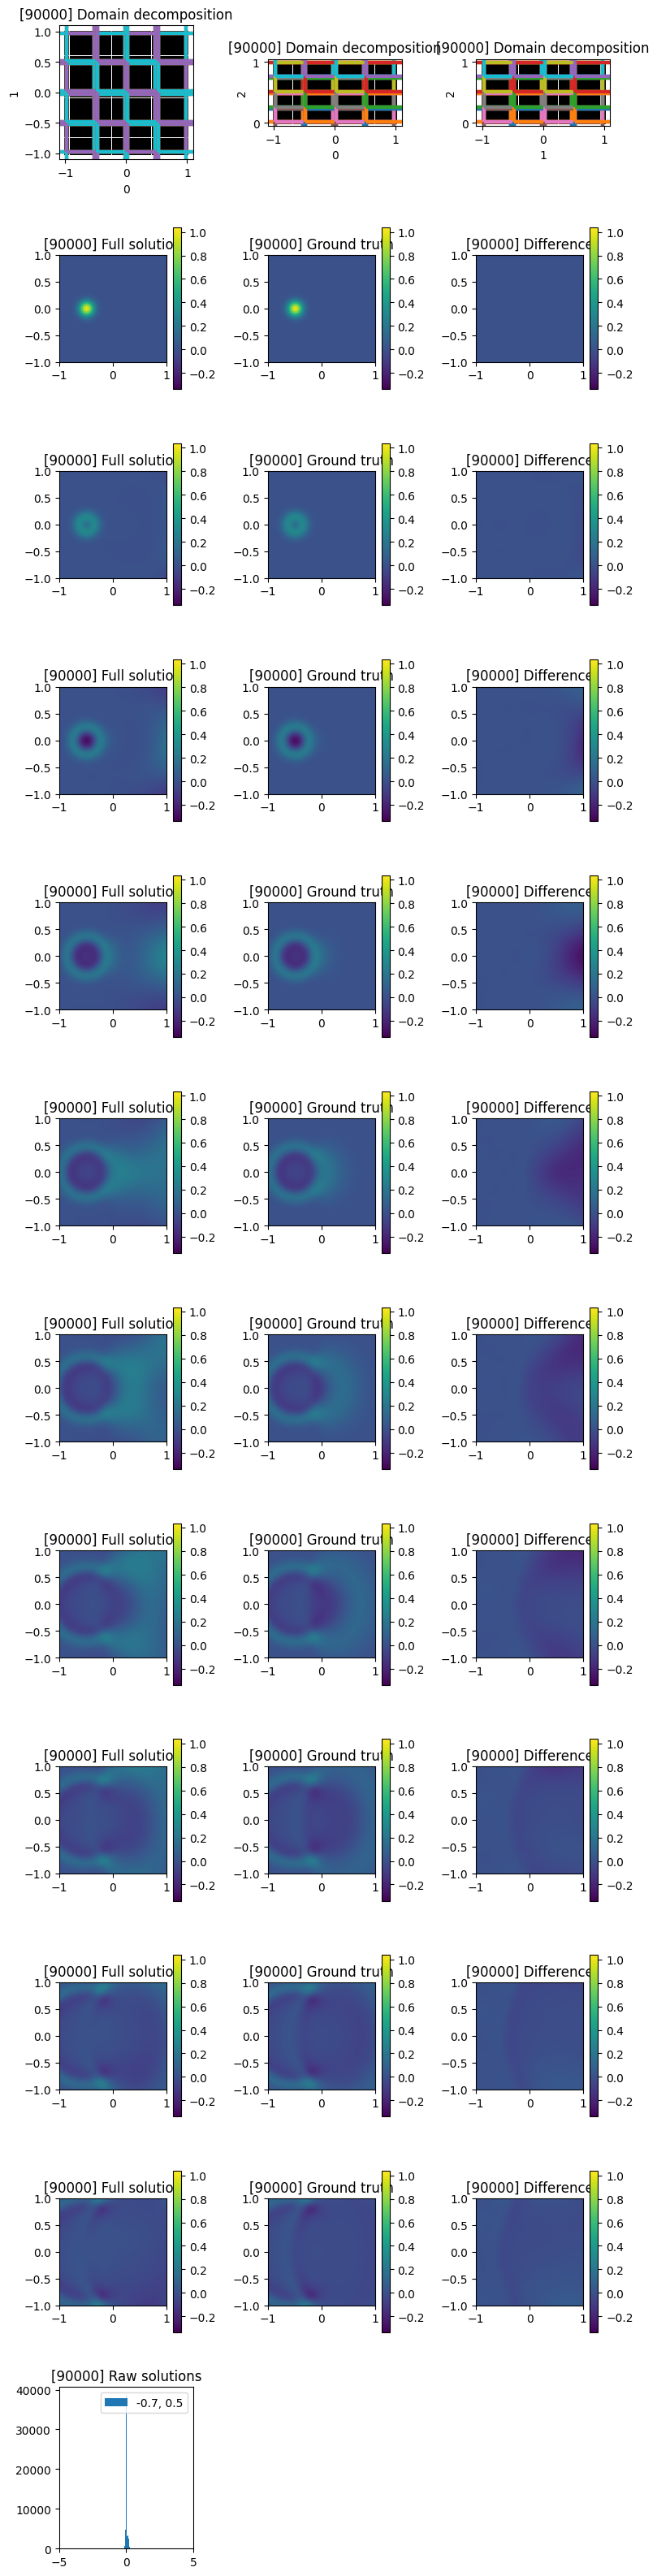

[INFO] 2024-09-30 08:16:12 - [i: 90000/90000] Training complete


In [109]:
run = FBPINNTrainer(c)
all_params1,loss_log1,x_batch_test1,model_fns1= run.train()

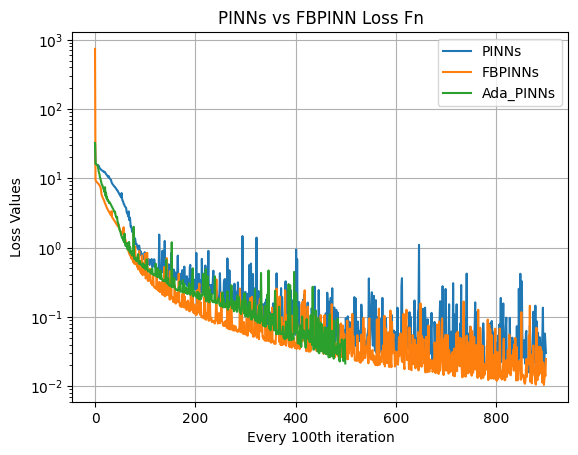

In [131]:
np.save("/home/bharath/Desktop/aps_images/2d_hetero_fbpinnsxxx_90k",loss_log1)
plt.plot(loss_log,label='PINNs')
plt.plot(loss_log1,label='FBPINNs') 
plt.plot(loss_log2,label="Ada_PINNs")
plt.yscale('log')
plt.ylabel('Loss Values')
plt.xlabel('Every 100th iteration')
plt.legend()
plt.title("PINNs vs FBPINN Loss Fn")
plt.grid()
plt.savefig('/home/bharath/Desktop/aps_images/ddd_losss.png',format='png',dpi=600)

In [132]:
#TEST F50
u_test2,u_raw_test2= PINN_model_jit(all_params2,x_batch_test2,model_fns2,verbose=True)
u_test2 = u_test2.reshape(50,50,10)

[INFO] 2024-09-30 14:34:06 - x_batch
[INFO] 2024-09-30 14:34:06 - (25000, 3), float32, DynamicJaxprTracer


In [90]:
import matplotlib.pyplot as plt
problem = WaveEquationInterfaceVelocity3D2
ps_ = problem.init_params()
all_params = {"static":{"problem":ps_[0]}, "trainable":{"problem":ps_[1]}}

batch_shape = (50,50,10)
x_batch = RectangularDomainND._rectangle_samplerND(None, "grid", np.array([-1, -1, 0]), np.array([1, 1, 1]), batch_shape)
c = problem.c_fn(all_params,x_batch)
velmodel = c.reshape(batch_shape) 
u= problem.exact_solution(all_params, x_batch, batch_shape) 
u = u.reshape(batch_shape)
uc = np.zeros_like(x_batch)[:,0:1]
uc = problem.constraining_fn(all_params, x_batch, uc).reshape(batch_shape)

[INFO] 2024-09-29 23:56:26 - Running seismicCPML2D (246, 246, 568)..


In [42]:
u_test.shape

(50, 50, 10)

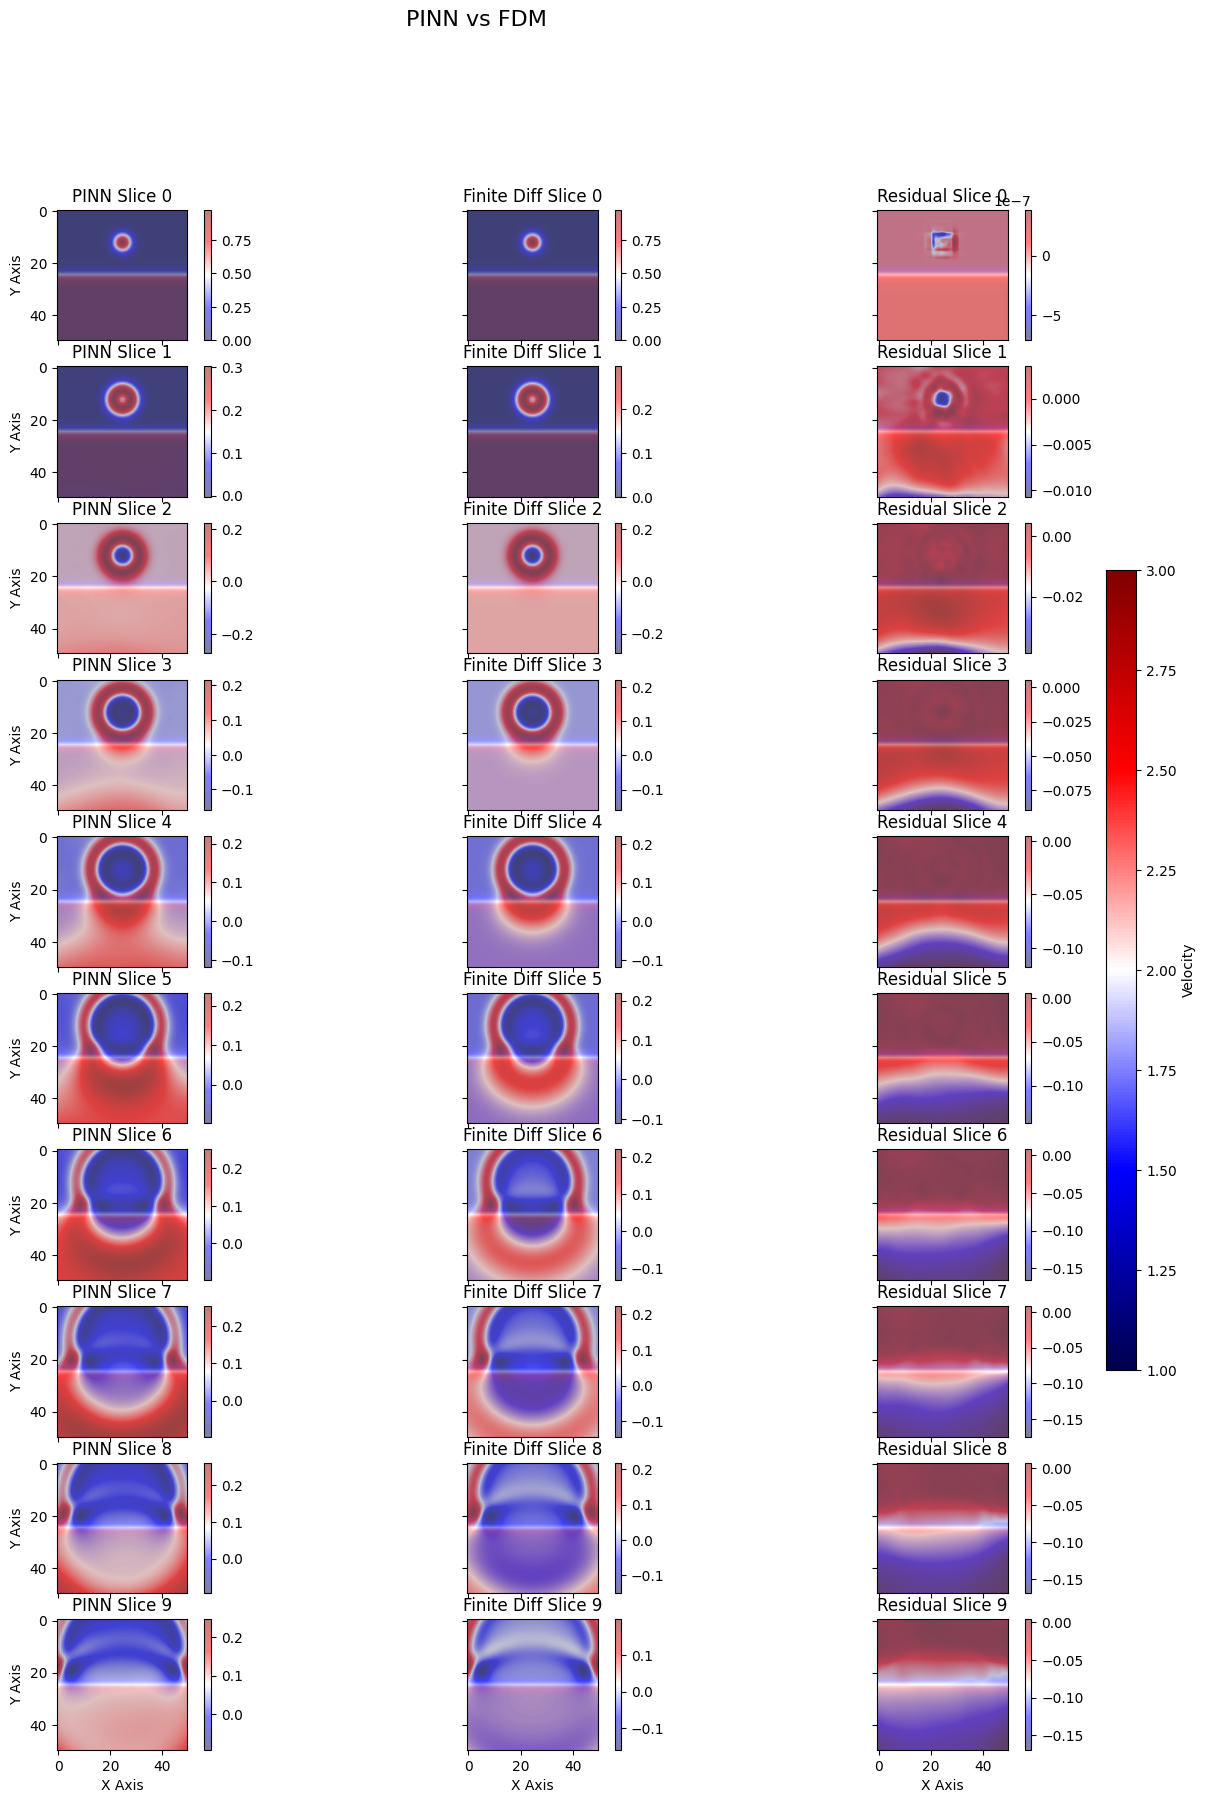

In [110]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar

def plot_seismic_slices(u_testFCN, u, vel_model, num_slices=10, interpolation='none', cmap='seismic', save_path=None, dpi=600):
    """
    Function to create 5 rows and 3 columns of subplots showing slices from the provided arrays.

    Parameters:
    u_testFCN: 3D array for PINN data
    u: 3D array for Finite Difference data
    vel_model: 2D array representing the velocity model to overlay
    num_slices: Number of slices to display (default: 5)
    interpolation: Interpolation method for imshow (default: 'none')
    cmap: Colormap to use for imshow (default: 'seismic')
    save_path: Path to save the figure (default: None, no saving)
    dpi: Resolution for saving the figure in DPI (default: 600)
    """
    
    # Create subplots with 5 rows and 3 columns, sharing X and Y axes
    fig, axs = plt.subplots(num_slices, 3, figsize=(15, 20), sharex=True, sharey=True)

    # Create a shared colorbar for the velocity model
    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position for the single colorbar
    vmin, vmax = vel_model.min(), vel_model.max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(sm, cax=cax, label='Velocity')

    for i in range(num_slices):
        # Plot for PINN data (left column), overlaying the velocity model
        axs[i, 0].imshow(vel_model[:,:,0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im1 = axs[i, 0].imshow(u_testFCN[:,:,i], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 0].set_title(f'PINN Slice {i}')
        plt.colorbar(im1, ax=axs[i, 0])  # Add colorbar for PINN solution

        # Plot for Finite Difference data (middle column), overlaying the velocity model
        axs[i, 1].imshow(vel_model[:,:,0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im2 = axs[i, 1].imshow(u[:,:,i], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 1].set_title(f'Finite Diff Slice {i}')
        plt.colorbar(im2, ax=axs[i, 1])  # Add colorbar for Finite Difference solution

        # Plot for the residual (right column), overlaying the velocity model
        axs[i, 2].imshow(vel_model[:,:,0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im3 = axs[i, 2].imshow(u[:,:,i] - u_testFCN[:,:,i], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 2].set_title(f'Residual Slice {i}')
        plt.colorbar(im3, ax=axs[i, 2])  # Add colorbar for Residual

        # Label X and Y axes
        axs[i, 0].set_ylabel("Y Axis")
        axs[num_slices - 1, 0].set_xlabel("X Axis")
        axs[num_slices - 1, 1].set_xlabel("X Axis")
        axs[num_slices - 1, 2].set_xlabel("X Axis")
    
    # Set the overall title
    fig.suptitle("PINN vs FDM", fontsize=16)

    # Adjust layout for better appearance
    #plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Leave space for the title and single colorbar
    
    # Save the figure if a path is provided with DPI = 600
    if save_path:
        plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight')

    # Show the figure
    plt.show()

# Example usage:
plot_seismic_slices(u_test, u, velmodel, interpolation='bilinear', cmap='seismic', save_path='/home/bharath/Desktop/aps_images/2d_hetero_pinns_90k.png', dpi=600)


In [60]:
c.decomposition

fbpinns.decompositions.RectangularDecompositionND

In [63]:
c.model_out_dir

'results/models/test/'

In [94]:
import jax.numpy as jnp
import pickle
from fbpinns.util.other import DictToObj
from fbpinns.analysis import load_model
from fbpinns.analysis import FBPINN_solution as FBPINN_solution_
from fbpinns.analysis import PINN_solution as PINN_solution_

In [114]:
with open("./results/summaries/test/constants_test.pickle", "rb") as f:
    c_dict = pickle.load(f)
    c = DictToObj(**c_dict, copy=True)


In [115]:
with open('./results/models/test/model_00090000.jax', "rb") as f:
    model = pickle.load(f)

# convert np arrays to jax
model = jax.tree_util.tree_map(lambda x: jnp.array(x) if isinstance(x, np.ndarray) else x, model)


In [116]:
i, all_params, all_opt_states, active, u_test_losses = model

In [117]:
problem, decomposition, network = c.problem, c.decomposition, c.network
model_fns = (decomposition.norm_fn, network.network_fn, decomposition.unnorm_fn, decomposition.window_fn, problem.constraining_fn)
takes, _, (_, _, _, cut_all, _) = get_inputs(x_batch, active, all_params, decomposition)
all_params_cut = {"static":cut_all(all_params["static"]),
                  "trainable":cut_all(all_params["trainable"])}
u_test1, *_ = FBPINN_model_jit(all_params_cut, x_batch, takes, model_fns)

[INFO] 2024-09-30 12:07:53 - x_batch
[INFO] 2024-09-30 12:07:53 - (25000, 3), float32, DynamicJaxprTracer
[INFO] 2024-09-30 12:07:53 - x_take
[INFO] 2024-09-30 12:07:53 - (159048, 3), float32, DynamicJaxprTracer


In [122]:
u_test1=u_test1.reshape(50,50,10)

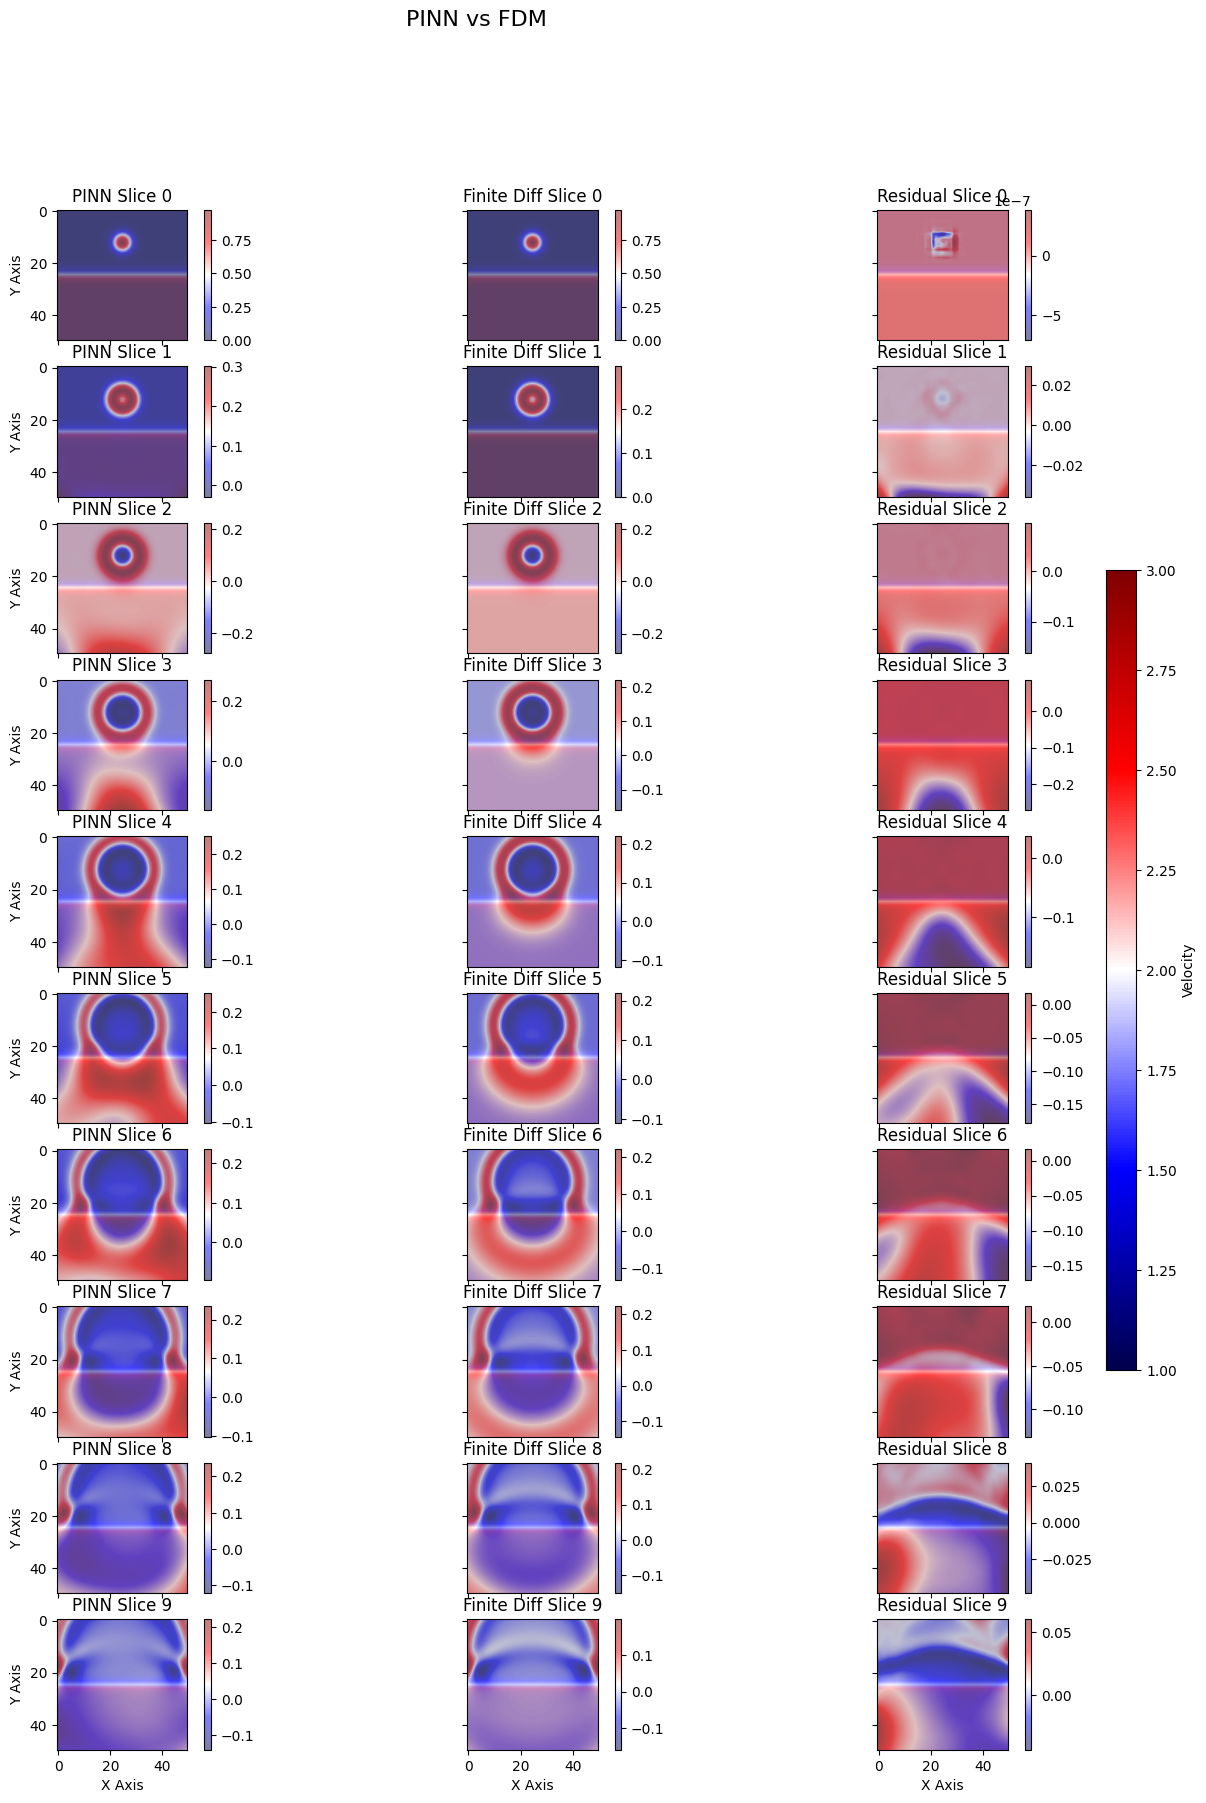

In [119]:
plot_seismic_slices(u_test1.reshape(50,50,10), u, velmodel, interpolation='bilinear', cmap='seismic', save_path='/home/bharath/Desktop/aps_images/2d_hetero_fbpinns_90k.png', dpi=600)

In [112]:
!pwd

/home/bharath/Desktop/tfb/FBPINNs-main/fbpinns


/home/bharath/miniconda3/envs/fbpinns/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/tmp/ipykernel_453034/402753760.py:73: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Leave space for the title and single colorbar


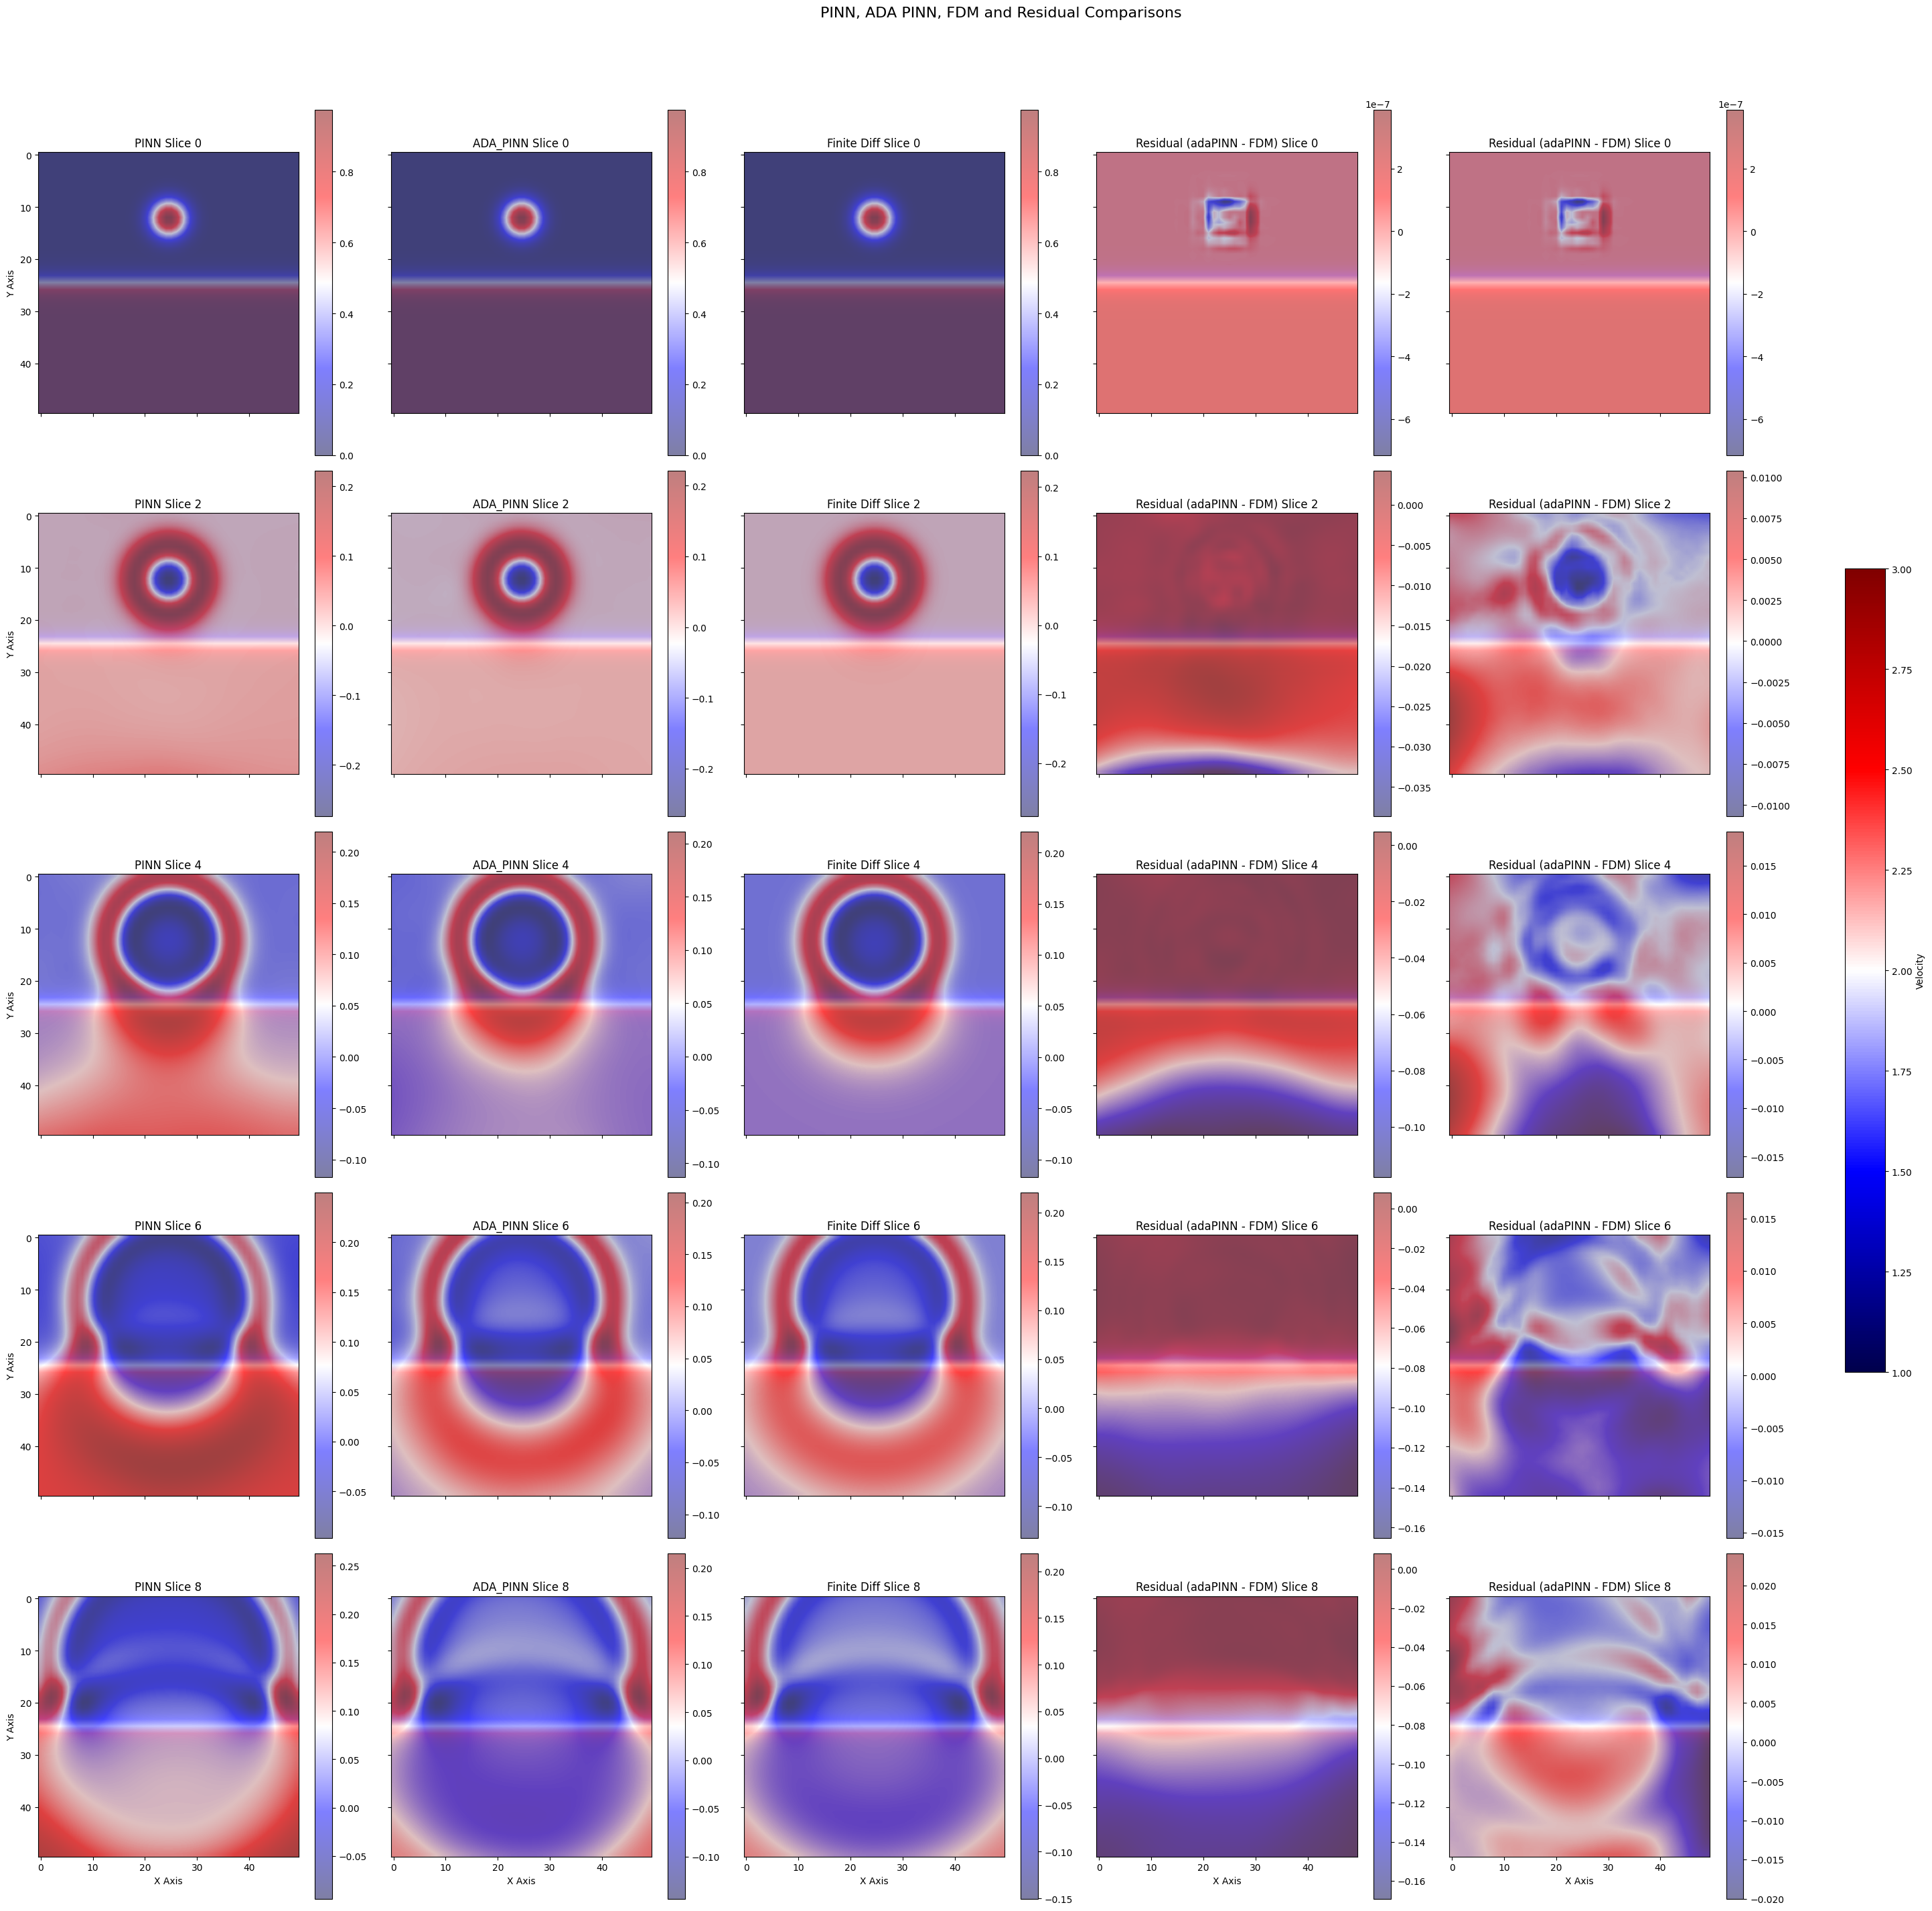

In [135]:
def plot_seismic_slices_extended(u_testFCN, u_fbPINN, u, vel_model, num_slices=5, interpolation='none', cmap='seismic', save_path=None, dpi=600):
    """
    Function to create 5 rows and 5 columns of subplots showing slices from the provided arrays.

    Parameters:
    u_testFCN: 3D array for PINN data
    u_fbPINN: 3D array for FB PINN data
    u: 3D array for Finite Difference data
    vel_model: 2D array representing the velocity model to overlay
    num_slices: Number of slices to display (default: 5)
    interpolation: Interpolation method for imshow (default: 'none')
    cmap: Colormap to use for imshow (default: 'seismic')
    save_path: Path to save the figure (default: None, no saving)
    dpi: Resolution for saving the figure in DPI (default: 600)
    """
    
    # Create subplots with 5 rows and 5 columns, sharing X and Y axes
    fig, axs = plt.subplots(num_slices, 5, figsize=(30, 30), sharex=True, sharey=True)

    # Create a shared colorbar for the velocity model
    cax = fig.add_axes([0.92, 0.3, 0.02, 0.4])  # Position for the single colorbar
    vmin, vmax = vel_model.min(), vel_model.max()
    norm = plt.Normalize(vmin=vmin, vmax=vmax)
    sm = cm.ScalarMappable(norm=norm, cmap=cmap)
    plt.colorbar(sm, cax=cax, label='Velocity')

    # Plot every second snapshot
    slices = range(0, u_testFCN.shape[2], 2)[:num_slices]

    for i, slice_idx in enumerate(slices):
        # Plot for PINN data (first column)
        axs[i, 0].imshow(vel_model[:, :, 0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im1 = axs[i, 0].imshow(u_testFCN[:, :, slice_idx], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 0].set_title(f'PINN Slice {slice_idx}')
        plt.colorbar(im1, ax=axs[i, 0])  # Add colorbar for PINN solution

        # Plot for FB PINN data (second column)
        axs[i, 1].imshow(vel_model[:, :, 0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im2 = axs[i, 1].imshow(u_fbPINN[:, :, slice_idx], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 1].set_title(f'ADA_PINN Slice {slice_idx}')
        plt.colorbar(im2, ax=axs[i, 1])  # Add colorbar for FB PINN solution

        # Plot for Finite Difference data (third column)
        axs[i, 2].imshow(vel_model[:, :, 0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im3 = axs[i, 2].imshow(u[:, :, slice_idx], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 2].set_title(f'Finite Diff Slice {slice_idx}')
        plt.colorbar(im3, ax=axs[i, 2])  # Add colorbar for Finite Difference solution

        # Plot for residual (PINN - FDM) (fourth column)
        axs[i, 3].imshow(vel_model[:, :, 0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im4 = axs[i, 3].imshow(u[:, :, slice_idx] - u_testFCN[:, :, slice_idx], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 3].set_title(f'Residual (adaPINN - FDM) Slice {slice_idx}')
        plt.colorbar(im4, ax=axs[i, 3])  # Add colorbar for Residual (PINN - FDM)

        # Plot for residual (FB PINN - FDM) (fifth column)
        axs[i, 4].imshow(vel_model[:, :, 0], cmap=cmap, alpha=0.5, interpolation=interpolation)
        im5 = axs[i, 4].imshow(u[:, :, slice_idx] - u_fbPINN[:, :, slice_idx], cmap=cmap, alpha=0.5, interpolation=interpolation)
        axs[i, 4].set_title(f'Residual (adaPINN - FDM) Slice {slice_idx}')
        plt.colorbar(im5, ax=axs[i, 4])  # Add colorbar for Residual (FB PINN - FDM)

        # Label X and Y axes
        axs[i, 0].set_ylabel("Y Axis")
        axs[num_slices - 1, 0].set_xlabel("X Axis")
        axs[num_slices - 1, 1].set_xlabel("X Axis")
        axs[num_slices - 1, 2].set_xlabel("X Axis")
        axs[num_slices - 1, 3].set_xlabel("X Axis")
        axs[num_slices - 1, 4].set_xlabel("X Axis")

    # Set the overall title
    fig.suptitle("PINN, ADA PINN, FDM and Residual Comparisons", fontsize=16)

    # Adjust layout for better appearance
    plt.tight_layout(rect=[0, 0.03, 0.9, 0.95])  # Leave space for the title and single colorbar
    
    # Save the figure if a path is provided with DPI = 600
    if save_path:
        plt.savefig(save_path, format='png', dpi=dpi, bbox_inches='tight')

    # Show the figure
    plt.show()

# Example usage:
plot_seismic_slices_extended(u_test, u_test2, u, velmodel, interpolation='bilinear', cmap='seismic', save_path='/home/bharath/Desktop/aps_images/ada_2d_hetero_pinns_90k.png', dpi=600)

